[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Parameter terbaik: {'multinomialnb__alpha': 0.1, 'tfidfvectorizer__max_features': 5000}
Skor terbaik: 0.81

Akurasi Model pada Test Set: 0.85

Laporan Klasifikasi:
              precision    recall  f1-score   support

     Negatif       0.81      0.85      0.83        20
      Netral       0.84      0.80      0.82        20
     Positif       0.90      0.90      0.90        20

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60


Teks: 'Proyek IKN berkembang pesat dengan dukungan pemerintah'
Kategori Prediksi: Netral

Teks: 'Kontroversi kebijakan IKN memicu debat publik'
Kategori Prediksi: Netral


<ipython-input-13-f9a1607ead41>:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


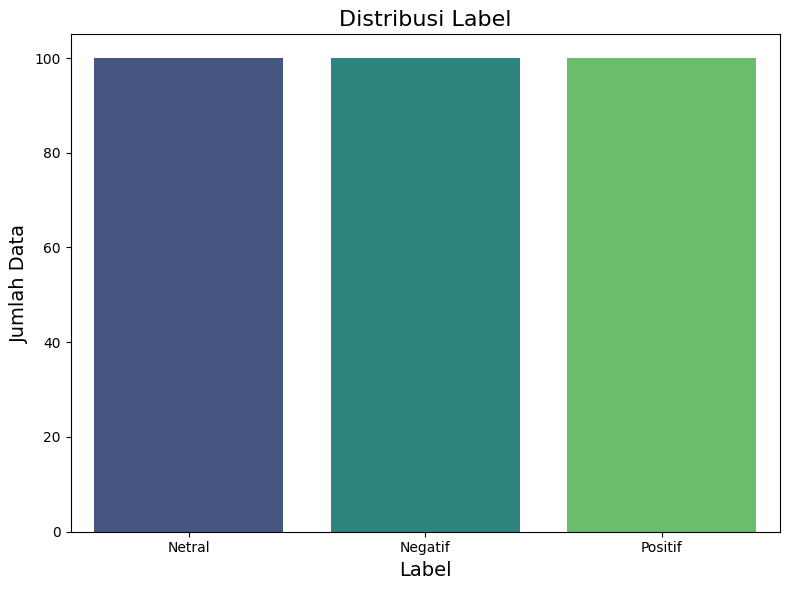

In [ ]:
# Install required packages
!pip uninstall nltk -y -q
!pip install pandas numpy nltk Sastrawi wordcloud seaborn matplotlib scikit-learn -q

import pandas as pd
import numpy as np
import re
import logging
from nltk.tokenize import word_tokenize
import nltk
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Clear NLTK data and reinstall
import shutil
import os
for path in nltk.data.path:
    if os.path.exists(path):
        shutil.rmtree(path, ignore_errors=True)

nltk.download('punkt')
nltk.download('punkt_tab')

# Inisialisasi logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Load data preprocessed
try:
    df = pd.read_csv('ikn_news_preprocessed_final.csv')  # Perbaikan: Ganti file dan tambah tanda kutip penutup
    logger.info("Berhasil memuat file ikn_news_preprocessed_final.csv")
except FileNotFoundError:
    logger.error("ikn_news_preprocessed_final.csv tidak ditemukan.")
    raise

# Pastikan kolom yang diperlukan ada
required_columns = ['filtered_content', 'label']  # Gunakan filtered_content yang sudah dipreproses
if not all(col in df.columns for col in required_columns):
    missing_cols = [col for col in required_columns if col not in df.columns]
    logger.error(f"Kolom yang hilang: {missing_cols}")
    raise ValueError(f"DataFrame tidak memiliki kolom yang diperlukan: {missing_cols}")

# Pisahkan fitur (teks) dan label
X = df['filtered_content'].fillna('')  # Gunakan filtered_content sebagai input
y = df['label']

# Bagi data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Definisikan pipeline dengan TF-IDF dan MultinomialNB
pipeline_nb = make_pipeline(
    TfidfVectorizer(
        stop_words=['yang', 'dan', 'di', 'dengan', 'untuk', 'pada', 'ini', 'dari', 'ke', 'dalam', 'tersebut', 'adalah', 'oleh'],
        max_features=5000,
        ngram_range=(1, 2)  # Tambahkan bigram untuk konteks lebih baik
    ),
    MultinomialNB()
)

# Definisikan parameter grid untuk tuning
param_grid = {
    'tfidfvectorizer__max_features': [3000, 5000, 7000],
    'multinomialnb__alpha': [0.1, 0.5, 1.0]
}

# Lakukan GridSearchCV untuk menemukan parameter terbaik
grid_search = GridSearchCV(pipeline_nb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Cetak parameter terbaik
print(f"Parameter terbaik: {grid_search.best_params_}")
print(f"Skor terbaik: {grid_search.best_score_:.2f}")

# Evaluasi model terbaik
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAkurasi Model pada Test Set: {accuracy:.2f}")
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred))

# Prediksi teks baru
new_texts = [
    "Proyek IKN berkembang pesat dengan dukungan pemerintah",
    "Kontroversi kebijakan IKN memicu debat publik"
]
predictions = grid_search.predict(new_texts)

# Menampilkan hasil prediksi
for text, pred in zip(new_texts, predictions):
    print(f"\nTeks: '{text}'")
    print(f"Kategori Prediksi: {pred}")

# Visualisasi distribusi label
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribusi Label', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Jumlah Data', fontsize=14)
plt.tight_layout()
plt.savefig('label_distribution.png')
plt.show()